# Assignment

In [2]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
from Policy import *

size_board = 4

#### The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.

#### Initialize env & parameters

In [3]:
## INITIALISE THE ENVIRONMENT
env = Chess_Env(size_board)
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200.
from Q_values import Q_values
from SARSA import sarsa
from Double_Q import Double_Q

np.random.seed(22)

S, X, allowed_a = env.Initialise_game()

N_in = np.shape(X)[0]  ## INPUT SIZE
N_h = 200  ## NUMBER OF HIDDEN NODES
N_a = np.shape(allowed_a)[0]  # TOTAL NUMBER OF POSSIBLE ACTIONS

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)
epsilon_0 = 0.4 # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.2     # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.7  # THE DISCOUNT FACTOR
eta = 0.02        # THE LEARNING RATE
## for attaching label of output, e.g. data file.etc
label_tag = "gamma_07_eps_04_beta_20000"

## turn on experience replay
EXP_REPLAY = False

## no need to change this part
momentum = 0.7
# how fast the weights copied from target network to online network
double_q_update_coe = 0.1

## INITALISE AGENT and NEURAL NETWORK
q_value = Q_values([N_in, N_h, N_a])
q_value.nn.momentum = momentum
q_value.gamma = gamma

sarsa_v = sarsa([N_in, N_h, N_a])
sarsa_v.nn.momentum = momentum
sarsa_v.gamma = gamma

double_q_v = Double_Q([N_in, N_h, N_a])
double_q_v.Q_primary.nn.momentum = momentum
double_q_v.gamma = gamma
double_q_v.update_coefficient = double_q_update_coe

N_episodes = 70000  # THE NUMBER OF GAMES TO BE PLAYED

## to stop training when get a model of avg_R of 1 in validation Test
early_stop = False
## when steps < N_threshold, stop training
N_threshold = 2.1


#### Common Functions (non-training)

In [18]:
## choose action with the largest value. Used in validation not in training update function.
## if no positive action is allowed, ramdonly choose one.
## during training process, this case can happend in validation.
def agent_action(value_function_model, X, allowed_a):
    (V, _) = value_function_model(X)
    allow_v = np.copy(V)
    allow_v[np.where(allowed_a.flatten() != 1)] = 0
    if (np.max(allow_v) == 0):
        return np.random.permutation(np.where(allowed_a.flatten() == 1)[0])[0]
    else:
        return np.argmax(allow_v)
# play one game and return R and steps
def play_one_game(value_function, max_step=16):
    S, X, allowed_a = env.Initialise_game()  # INITIALISE GAME
    Done = 0  # SET Done=0 AT THE BEGINNING
    i = 1  # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    while Done == 0:
        a_agent = agent_action(value_function, X, allowed_a)
        S, X, allowed_a, R, Done = env.OneStep(a_agent)
        if Done:
            return (R, i)
        if i > max_step:
            return (R, i)
        i = i + 1

## validate performance
def period_validate(function_model, validate_games):
    # SAVING VARIABLES
    R_save_temp = np.zeros([validate_games, 1])
    N_moves_save_temp = np.zeros([validate_games, 1])
    for n in range(validate_games):
        (R, n_moves) = play_one_game(function_model)
        R_save_temp[n] = np.copy(R)
        N_moves_save_temp[n] = np.copy(n_moves)
    return (np.mean(R_save_temp), np.mean(N_moves_save_temp))

## exp moving average
def EMA(x, y):
    k = 50 / len(x)
    ema_seq = []
    ema_prev = 0
    for t in range(0, len(x)):
        y_t = y[t] * k + ema_prev * (1 - k)
        ema_prev = y_t
        ema_seq.append(y_t)
    return (x, ema_seq)

## save/load model
import pickle
def save_model(name="saved_model.pkl"):
    with open(f"{name}", 'wb') as output:
        pickle.dump(sarsa_v, output, pickle.HIGHEST_PROTOCOL)
        pickle.dump(q_value, output, pickle.HIGHEST_PROTOCOL)
        pickle.dump(double_q_v, output, pickle.HIGHEST_PROTOCOL)

def load_model(name="saved_model.pkl"):
    with open(f"{name}", 'rb') as input:
        loaded_sarsa_v = pickle.load(input)
        loaded_q_value = pickle.load(input)
        loaded_double_q_v = pickle.load(input)
        return (loaded_sarsa_v, loaded_q_value, loaded_double_q_v)

#### Experience Replay

In [19]:
## this function looks somehow not so elegent.  
# history sequence [((x_t, allowed_next, done), action_t, r_t)]
def experience_replay(history, agent, model_next_q, model_value_function, eta):
    ## sample from history
    his_copy = np.copy(history)
    shuffle = np.random.permutation((len(his_copy)-1))
    sample_num = np.random.randint(1, (len(history)-1))
    
    ## mini batch
    update = []
    for i in range(sample_num):
        his_item = his_copy[shuffle[i]]
        x = his_item[0][0]
        r = his_item[2]
        partial = []
        if (i+1 >= len(history) or his_item[0][2]==1):
            ## last step in history
            (predict_q, neuron_val) = model_value_function(x)
            temp_delta = r - predict_q
            ## feed agent.nn get partial
            partial = agent.nn.partial_derivative(agent.nn.W_bias, temp_delta, neuron_val)
        else:

            (predict_q, neuron_val)=model_value_function(x)

            next = his_copy[shuffle[i]+1]
           
            next_x = next[0][0]
            allowed_action = next[0][1]

            ## value + neuron value
            (next_value, _) = model_value_function(next_x)
            ##  R + 
            y = (r +  model_next_q(next_value, allowed_action, next_x))
            temp_delta = y - predict_q
            partial = agent.nn.partial_derivative(
                agent.nn.W_bias, temp_delta, neuron_val
            )
        if(len(update) == 0):
            update = partial
            continue
        for pi in range(len(partial)):
            update[pi]= (np.add(update[pi][0], partial[pi][0]), np.add(update[pi][1], partial[pi][1]))

    for ui in range(len(update)):
        update[ui] = (update[ui][0]/sample_num, update[ui][1]/sample_num)
    agent.nn.momentum_gradient_decent_update(eta, update)


#### Traning function

In [20]:
from collections import deque
his_size = 30

import warnings
import warnings
warnings.filterwarnings("ignore")

def train(N_episodes, epsilon_0, agent, model_value_function, model_training_function, model_calculate_next_R):
    # global sarsa_v
    # TRAINING LOOP BONE STRUCTURE
    R_period_seq = []
    N_period_step_seq = []
    x_period_axis = []

    R_training_seq = []
    N_training_seq = []
    x_training_seq = []

    hist = deque([], maxlen = his_size)

    for n in range(N_episodes):
        epsilon_f = epsilon_0 / (1 + beta * n)  ## DECAYING EPSILON
        sarsa_v.epsilon = epsilon_f

        Done = 0  ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        
        S, X, allowed_a = env.Initialise_game()

        while Done == 0:  ## START THE EPISODE
            ## value for all actions from current value function
            (value_s, neuron_value) = model_value_function(X)
            ## based on the alue, choose an action
            a_agent = epsilon_greedy(value_s, np.asarray(allowed_a), epsilon_f)
            ## feed action into env, get next state
            S_next, X_next, allowed_a_next, R, Done = env.OneStep(a_agent)
            
            ## save history for experince replay
            ## ((x_t, allowed_action), action_t, r_t)
            hist.append(((X, allowed_a, Done), a_agent, R))
            
            if Done == 1:
                ## No need to calculate future s' value
                model_training_function(eta, neuron_value, a_agent, R, value_s)

                ## experience replay
                if (EXP_REPLAY and len(hist) == his_size):
                    experience_replay(hist, agent, model_calculate_next_R, model_value_function, eta )
                break
            else:
                ## evaluate value of next state, get value for all possibile actions
                (V_next, _) = model_value_function(X_next)
                ## calculate future value. 
                ## e.g. for SARSA use epsilon greedy to choose an action and get its value*gamma)
                future_R = model_calculate_next_R(V_next, allowed_a_next, X_next)
                
                ## train the model, equal to SGD update
                ## inside the function, model calculate delta and do gradient descent.
                model_training_function(eta, neuron_value, a_agent, future_R, value_s)

            # NEXT STATE AND CO. BECOME ACTUAL STATE...
       
            S = np.copy(S_next)
            X = np.copy(X_next)
            allowed_a = np.copy(allowed_a_next)

        ############# record training data###############
        (R, n_moves) = play_one_game(model_value_function)
        # data of each episodes
        x_training_seq.append(n)
        R_training_seq.append(R)
        N_training_seq.append(n_moves)
        #######################################

        ######### periodly validate performance ########################
        if (n % 1000 == 0):
            (avg_R, avg_n) = period_validate(model_value_function, 200)
            print(f"\r Training process {np.round(n / N_episodes * 100, 2)}%  "
                  f"avg_R: {np.round(avg_R, 2)}, avg_steps:{np.round(avg_n, 2)}", end="", flush=True)
            x_period_axis.append(n)
            R_period_seq.append(avg_R)
            N_period_step_seq.append(avg_n)
            # early stop to preserve best model so far
            if (early_stop and avg_R > 0.99 and avg_n < N_threshold):
                return [(x_period_axis, R_period_seq, N_period_step_seq),
                        (x_training_seq, R_training_seq, N_training_seq)]
        ############################################################

    return [(x_period_axis, R_period_seq, N_period_step_seq),
            (x_training_seq, R_training_seq, N_training_seq)]


#### Q Learning Training

In [21]:
Q_training_his = train(N_episodes, epsilon_0, q_value,
                        ## model value function
                        lambda X: q_value.q_values(X),
                        ## model gradient descent 
                        lambda eta, neuron_value, a_agent, R, qv_s: q_value.update_q_func(eta, neuron_value, a_agent, R, qv_s),
                        ## model choose next action and future reward
                        lambda V_next, allowed_next,X_next: q_value.calculate_next_Q(V_next, allowed_next, X_next)
                        )
(Q_x_axis, Q_R_seq, Q_N_step_seq) = Q_training_his[0]
(Q_x_training_seq, Q_R_training_seq, Q_N_training_seq) = Q_training_his[1]
print()

 Training process 98.57%  avg_R: 1.0, avg_steps:2.54


#### SARSA Training

In [22]:
Sarsa_his = train(N_episodes, epsilon_0, sarsa_v,
                  lambda X: sarsa_v.sarsa_value(X),
                  lambda eta, neuron_value, a_agent, R, qv_s: sarsa_v.update_sarsa_func(eta, neuron_value, a_agent, R,
                                                                                        qv_s),
                  lambda V_next, allowed_next, X_next: sarsa_v.calculate_next_V(V_next, allowed_next, X_next)
                  )
(Sarsa_x_axis, Sarsa_R_seq, Sarsa_N_step_seq) = Sarsa_his[0]
(Sarsa_x_training_seq, Sarsa_R_training_seq, Sarsa_N_training_seq) = Sarsa_his[1]
print()

 Training process 98.57%  avg_R: 1.0, avg_steps:2.46


#### Double-Q Training

In [23]:
double_q_his = train(N_episodes, epsilon_0, double_q_v,
                     lambda X: double_q_v.q_primary_value(X),
                     lambda eta, neuron_value, a_agent, R, qv_s: double_q_v.update_func(eta, neuron_value, a_agent, R,
                                                                                        qv_s),
                     lambda V_next, allowed_next, X_next: double_q_v.next_action_Q(V_next, allowed_next, X_next)
                     )
(dq_x_axis, dq_R_seq, dq_N_step_seq) = double_q_his[0]
(dq_x_training_seq, dq_R_training_seq, dq_N_training_seq) = double_q_his[1]
print()

#### Test Trained Model

In [24]:
import sys, importlib
importlib.reload(sys.modules['Chess_env'])

def test(agent, agent_tag):
    N_episodes = 20000
    R_save = np.zeros([N_episodes, 1])
    N_moves_save = np.zeros([N_episodes, 1])
    for n in range(N_episodes):
        ## no max step limit amost
        (R, i) = play_one_game(agent, 100)
        R_save[n] = np.copy(R)
        N_moves_save[n] = np.copy(i)
    print(f'Agent {agent_tag}, Average reward:', np.mean(R_save), 'Number of steps: ', np.mean(N_moves_save))
    return (np.mean(R_save), np.mean(N_moves_save))

test(lambda X_in: q_value.q_values(X_in), "Q_agent")
test(lambda X_in: sarsa_v.sarsa_value(X_in), "Sarsa_agent")
test(lambda X_in: double_q_v.q_primary_value(X_in), "Double Q")


Agent Q_agent, Average reward: 1.0 Number of steps:  2.54245
Agent Sarsa_agent, Average reward: 0.9999 Number of steps:  2.45305


(0.9999, 2.45305)

#### Save Model


In [25]:
# to save model of the above 3, enable this line
save_model(f"model_{label_tag}.pkl")

#### Sample code to load saved model by name, test their performance

In [26]:
## load saved model
# (loaded_sarsa_v, loaded_q_value, loaded_double_q_v) = load_model("model_9995.pkl")
# test(lambda X_in: loaded_q_value.q_values(X_in), "Q_agent")
# test(lambda X_in: loaded_sarsa_v.sarsa_value(X_in), "Sarsa_agent")
# test(lambda X_in: loaded_double_q_v.q_primary_value(X_in), "Double Q")

#### Run saved mdel, evaluate their performance

In [27]:
## beta value, 00100 means beta=0.00100 .etc.
# b_list=["00100", "00200", "00300", "00500", "00700", "01000","02000","04000","10000","20000", "30000"]

## gamma value, 001 means .001, 
# 02 means 0.2, so as 07 040 055, 
# 85 and 99 means .85 and .99
# g_list=["001","02","07","040","055", "85", "99",]
# model_names = []
# for b in b_list:
#     model_names.append(f"gamma_07_eps_04_beta_{b}")
# for g in g_list:
#     model_names.append(f"eps_04_gamma_{g}")
  
# f = open("model_test.py", "a")
# for m in model_names:
#     (loaded_sarsa_v, loaded_q_value, loaded_double_q_v) = load_model(f"model_{m}.pkl")
#     (q_r, q_n) = test(lambda X_in: loaded_q_value.q_values(X_in), f"model_{m} Q")
#     (s_r, s_n) = test(lambda X_in: loaded_sarsa_v.sarsa_value(X_in), f"model_{m} Sarsa")
#     qr_o = f"{m}_q_test_r={str(q_r)}"
#     sr_o =f"{m}_sarsa_test_r={str(s_r)}"
#     qn_o = f"{m}_q_test_n={str(q_n)}"
#     sn_o = f"{m}_sarsa_test_n={str(s_n)}"
#     o = [qr_o, sr_o, qn_o, sn_o]
#     for s in o:
#       f.write(s+"\n")
# f.close()

#### save training process data

In [28]:
###

data_file = f"data_{label_tag}.py"

## save training process data
def assemble_data(label, x, avg_R, avg_N, x_training_seq, R_training_seq, N_training_seq):
    f_x=f"{label}_x_axis={str(x)}"
    f_avg_R = f"{label}_avg_R={str(avg_R)}"
    f_avg_N = f"{label}_avg_N={str(avg_N)}"
    f_x_training_seq = f"{label}_x_training_seq={str(x_training_seq)}"
    f_R_training_seq = f"{label}_R_training_seq={str(R_training_seq)}"
    f_N_training_seq = f"{label}_N_training_seq={str(N_training_seq)}"
    return [f_x, f_avg_R, f_avg_N, f_x_training_seq, f_R_training_seq, f_N_training_seq]

f = open(data_file, "a")
output = []
Q_data = assemble_data(f"{label_tag}_Q_Learning", Q_x_axis, Q_R_seq, Q_N_step_seq,
                       Q_x_training_seq, Q_R_training_seq, Q_N_training_seq )
SARSA_data = assemble_data(f"{label_tag}_SARSA", Sarsa_x_axis, Sarsa_R_seq, Sarsa_N_step_seq,
                           Sarsa_x_training_seq, Sarsa_R_training_seq, Sarsa_N_training_seq)
Dq_data = assemble_data(f"{label_tag}_Double_Q", dq_x_axis, dq_R_seq, dq_N_step_seq,
                        dq_x_training_seq, dq_R_training_seq, dq_N_training_seq)
output.extend(Q_data)
output.extend(SARSA_data)
output.extend(Dq_data)
for s in output:
    f.write(s+"\n")
    pass
f.close()

### plot training curves

In [29]:

def plot(title):
    plt.figure(1)
    plt.title(f"{title} Validation R value")
    plt.plot(Q_Learning_x_axis, Q_Learning_avg_R, label="Q Learning")
    plt.plot(SARSA_x_axis, SARSA_avg_R, label="SARSA")
    plt.plot(Double_Q_x_axis, Double_Q_avg_R, label="Double Q")
    plt.legend()
    plt.xlabel("episodes")
    plt.ylabel("R")

    plt.figure(2)
    plt.title(f"{title} Validation Checkmate steps")
    plt.plot(Q_Learning_x_axis, Q_Learning_avg_N, label="Q learning")
    plt.plot(SARSA_x_axis, SARSA_avg_N, label="SARSA")
    plt.plot(Double_Q_x_axis, Double_Q_avg_N, label="Double Q")
    plt.legend()
    plt.xlabel("episodes")
    plt.ylabel("steps")

    k = (len(SARSA_x_training_seq))
    (Sarsa_ema_x, Sarsa_R_ema) = EMA(SARSA_x_training_seq, SARSA_R_training_seq)
    (Q_ema_x, Q_R_ema) = EMA(Q_Learning_x_training_seq, Q_Learning_R_training_seq)
    (Dq_ema_x, Dq_R_ema) = EMA(Double_Q_x_training_seq, Double_Q_R_training_seq)
    (_, Sarsa_N_ema) = EMA(SARSA_x_training_seq, SARSA_N_training_seq)
    (_, Q_N_ema) = EMA(Q_Learning_x_training_seq, Q_Learning_N_training_seq)
    (_, Dq_N_ema) = EMA(Double_Q_x_training_seq, Double_Q_N_training_seq)

    plt.figure(3)
    plt.title(f"{title} R trend")
    plt.plot(Q_ema_x, Q_R_ema, label="Q learning")
    plt.plot(Sarsa_ema_x, Sarsa_R_ema, label="SARSA")
    plt.plot(Dq_ema_x, Dq_R_ema, label="Double Q")
    plt.legend()
    plt.xlabel("episodes")
    plt.ylabel("R")


    plt.figure(4)
    plt.title(f"{title} steps trend")
    plt.plot(Q_ema_x, Q_N_ema, label="Q learning")
    plt.plot(Sarsa_ema_x, Sarsa_N_ema, label="SARSA")
    plt.plot(Dq_ema_x, Dq_N_ema , label="Double Q")
    plt.xlabel("episodes")
    plt.ylabel("steps")
    plt.legend()



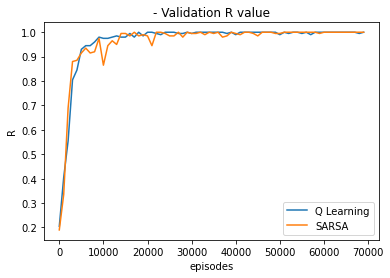

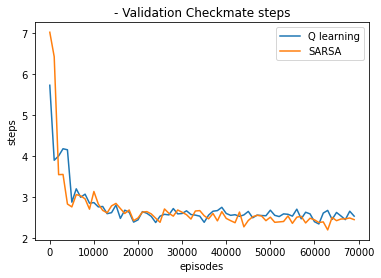

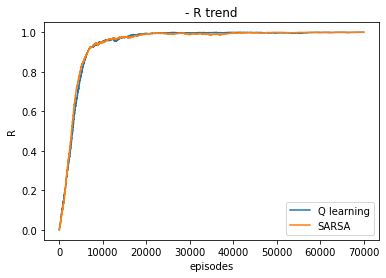

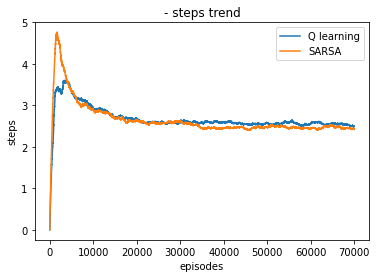

In [30]:
Q_Learning_x_axis = Q_x_axis
Q_Learning_avg_R = Q_R_seq
Q_Learning_avg_N =  Q_N_step_seq
SARSA_avg_N = Sarsa_N_step_seq
Double_Q_avg_N = dq_N_step_seq
SARSA_x_axis = Sarsa_x_axis
SARSA_avg_R = Sarsa_R_seq
Double_Q_x_axis = dq_x_axis
Double_Q_avg_R = dq_R_seq
SARSA_x_training_seq = Sarsa_x_training_seq
SARSA_R_training_seq = Sarsa_R_training_seq
SARSA_N_training_seq = Sarsa_N_training_seq
Q_Learning_x_training_seq = Q_x_training_seq
Q_Learning_R_training_seq = Q_R_training_seq 
Q_Learning_N_training_seq = Q_N_training_seq
Double_Q_x_training_seq = dq_x_training_seq
Double_Q_R_training_seq = dq_R_training_seq
Double_Q_N_training_seq = dq_N_training_seq
plot("-")